In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [3]:
# For normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [4]:
# Read the file
df = pd.read_csv('NSE-TATAGLOBAL11.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


There are multiple variables in the dataset – date, open, high, low, last, close, total_trade_quantity, and turnover.

The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.
High, Low and Last represent the maximum, minimum, and last price of the share for the day.

Total Trade Quantity is the number of shares bought or sold in the day and Turnover (Lacs) is the turnover of the particular company on a given date.

Another important thing to note is that the market is closed on weekends and public holidays.Notice the above table again, some date values are missing – 2/10/2018, 6/10/2018, 7/10/2018. Of these dates, 2nd is a national holiday while 6th and 7th fall on a weekend.

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable.

C:\Users\suhan\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


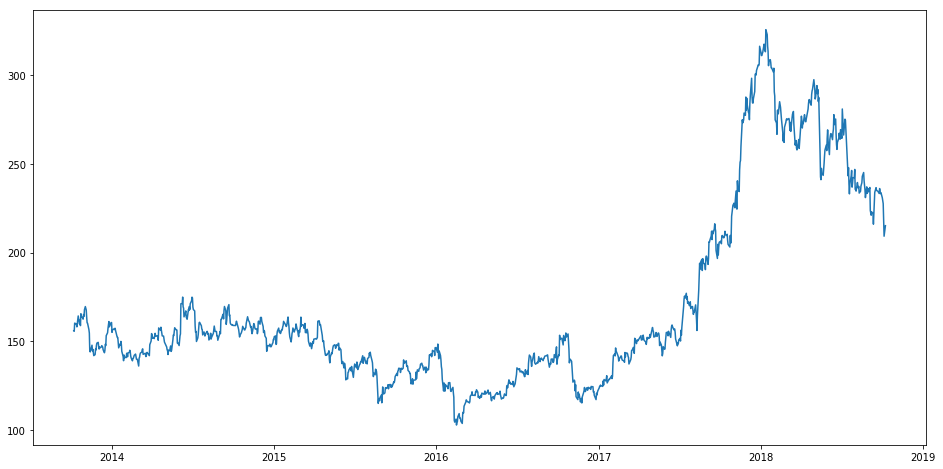

In [5]:
# setting index as date
df['Date'] = pd.to_datetime(df.Date, format = '%Y-%m-%d')
df.index = df['Date']

# plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label = 'Close Price History')

In [6]:
# Creating Dataframe with date and target variable
data = df.sort_index(ascending = True, axis = 0)
new_data = pd.DataFrame(index = range(0, len(df)), columns = ['Date', 'Close'])

for i in range(0, len(df)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

While splitting the data into train and validation, we cannot use random splitting since that will destroy the time component. So here I have set the last year’s data into validation and the 4 years’ data before that into train.

In [7]:
# splitting into train and validation
train = new_data[:987]
valid = new_data[987:]

In [8]:
new_data.shape, train.shape, valid.shape

((1235, 2), (987, 2), (248, 2))

In [9]:
train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()

(Timestamp('2013-10-08 00:00:00'),
 Timestamp('2017-10-06 00:00:00'),
 Timestamp('2017-10-09 00:00:00'),
 Timestamp('2018-10-08 00:00:00'))

In [10]:
# Make prediction for the validation set and check the RMSE using the actual values
preds = []
for i in range(0, 248):
    a = train['Close'][len(train) - 248 + i:].sum() + sum(preds)
    b = a/248
    preds.append(b)

In [11]:
# calculate rmse
rms = np.sqrt(np.mean(np.power((np.array(valid['Close']) - preds), 2)))
rms

104.51415465984348

C:\Users\suhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\suhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


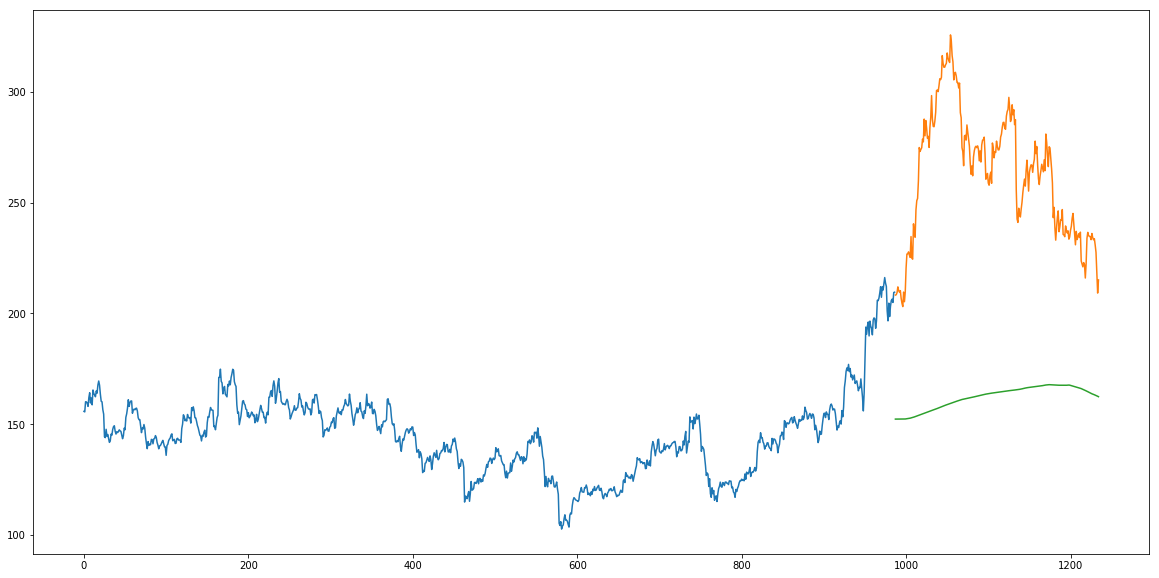

In [12]:
# plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

Inference

The RMSE value is close to 105 but the results are not very promising (as you can gather from the plot). The predicted values are of the same range as the observed values in the train set (there is an increasing trend initially and then a slow decrease).

### Linear Regression

In [13]:
# setting index as date values
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']

# sorting
data = df.sort_index(ascending=True, axis = 0)

# creating a separate dataset
new_data = pd.DataFrame(index=range(0, len(df)),columns = ['Date', 'Close'])

for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [14]:
# create features
from fastai.tabular import add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis = 1, inplace = True)    # elapsed will be the time stamp

In [15]:
fastai.__version__

NameError: name 'fastai' is not defined

This creates features such as:

‘Year’, ‘Month’, ‘Week’, ‘Day’, ‘Dayofweek’, ‘Dayofyear’, ‘Is_month_end’, ‘Is_month_start’, ‘Is_quarter_end’, ‘Is_quarter_start’,  ‘Is_year_end’, and  ‘Is_year_start’.

In [16]:
new_data['mon-fri'] = 0
for i in range(0, len(new_data)):
    if(new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'] = 1
    else:
        new_data['mon-fri'] = 0

In [17]:
# splitting into train and validation
train = new_data[:987]
valid = new_data[987:]

x_train = train.drop('Close', axis = 1)
y_train = train['Close']
x_valid = valid.drop('Close', axis = 1)
y_valid = valid['Close']


# Implement Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [18]:
# make prediction and find rmse
preds = model.predict(x_valid)
rms = np.sqrt(np.mean(np.power((np.array(y_valid) - np.array(preds)), 2)))
rms

121.16382449873976

C:\Users\suhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\suhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


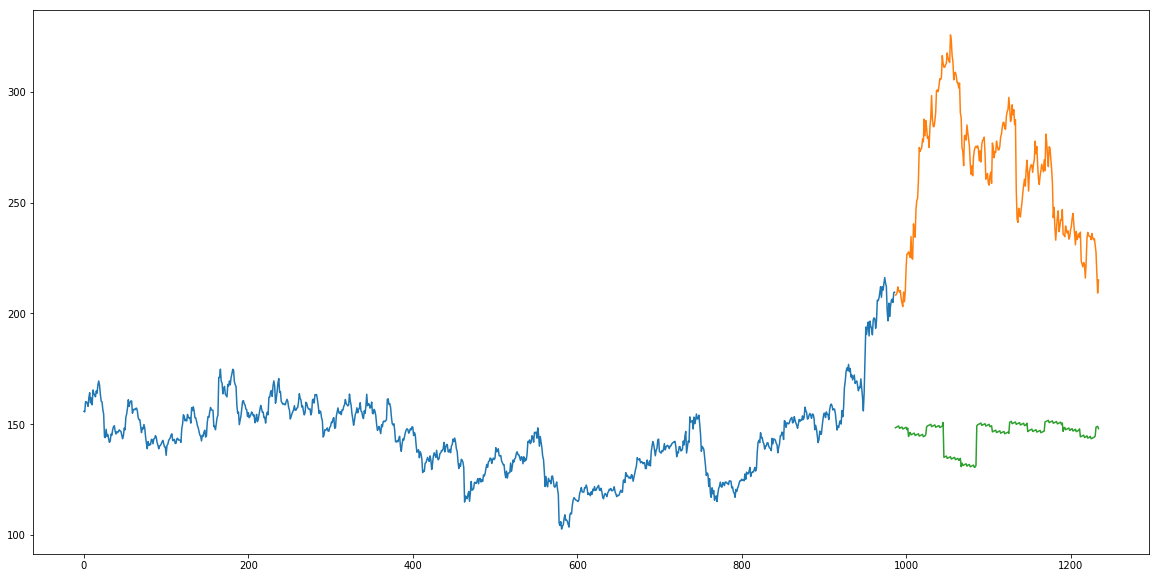

In [21]:
# plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[987:].index
train.index = new_data[:987].index

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

Inference

Linear regression is a simple technique and quite easy to interpret, but there are a few obvious disadvantages. One problem in using regression algorithms is that the model overfits to the date and month column. Instead of taking into account the previous values from the point of prediction, the model will consider the value from the same date a month ago, or the same date/month a year ago.

As seen from the plot above, for January 2016 and January 2017, there was a drop in the stock price. The model has predicted the same for January 2018. A linear regression technique can perform well for problems such as Big Mart sales where the independent features are useful for determining the target value.

### k-Nearest Neighbours

In [22]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

In [23]:
# scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

# using gridseach to find the best parameters
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

C:\Users\suhan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\suhan\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [24]:
# fit the model and make prediction
model.fit(x_train, y_train)
preds = model.predict(x_valid)

C:\Users\suhan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [25]:
# rmse
rms = np.sqrt(np.mean(np.power((np.array(y_valid) - np.array(preds)), 2)))
rms

114.820692914522

C:\Users\suhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\suhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


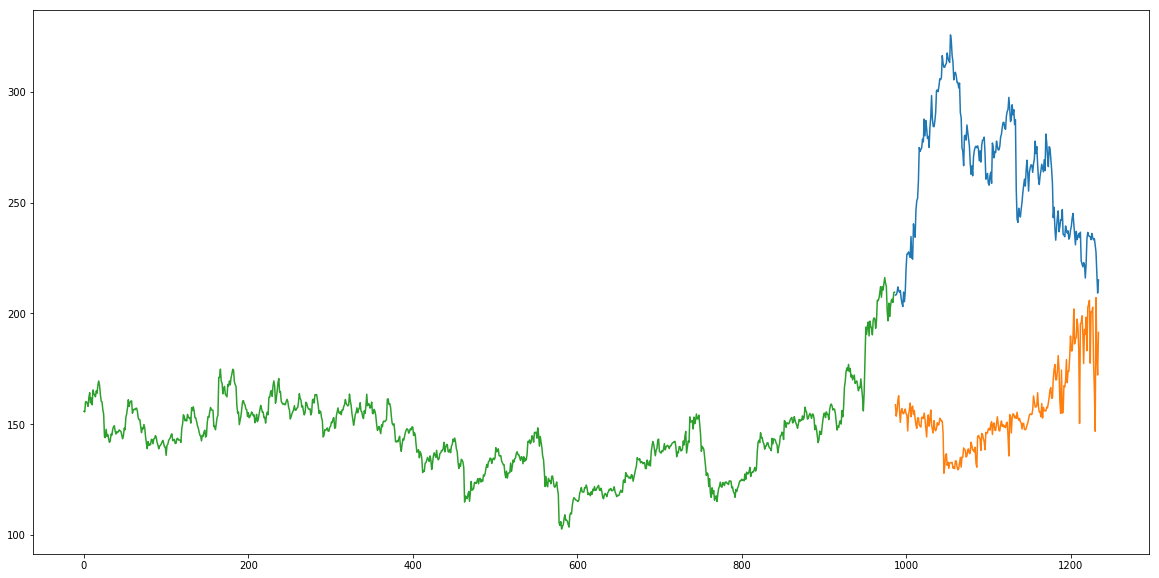

In [26]:
# plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

Inference

The RMSE value is almost similar to the linear regression model and the plot shows the same pattern. Like linear regression, kNN also identified a drop in January 2018 since that has been the pattern for the past years. We can safely say that regression algorithms have not performed well on this dataset.

### Auto ARIMA

In [27]:
from pyramid.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:987]
valid = data[987:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True)
model.fit(training)

forcast = model.predict(n_periods=248)
forcast = pd.DataFrame(forcast, index=valid.index, columns=['Prediction'])

C:\Users\suhan\Anaconda3\lib\site-packages\pyramid\__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4820.561, BIC=4844.968, Fit time=10.778 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5479.245, BIC=5489.008, Fit time=0.174 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5170.275, BIC=5189.801, Fit time=1.990 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4818.530, BIC=4838.055, Fit time=10.408 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4816.433, BIC=4840.840, Fit time=4.900 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=5170.275, BIC=5189.801, Fit time=2.047 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4818.339, BIC=4847.628, Fit time=25.823 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5481.156, BIC=5495.800, Fit time=0.433 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=4818.604, BIC=4852.774, Fit time=18.578 seconds
Fit ARIMA: order=(1, 1, 

In [28]:
# rmse
rms = np.sqrt(np.mean(np.power((np.array(valid['Close']) - np.array(forcast['Prediction'])), 2)))
rms

44.95520928371136

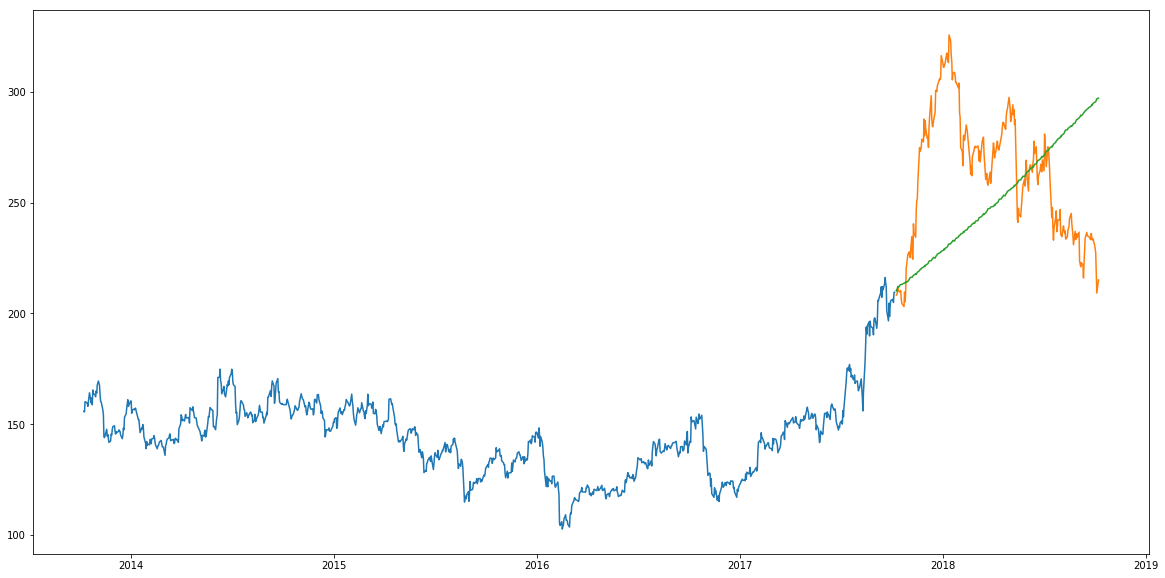

In [29]:
#plot
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forcast['Prediction'])

Inference

As we saw earlier, an auto ARIMA model uses past data to understand the pattern in the time series. Using these values, the model captured an increasing trend in the series. Although the predictions using this technique are far better than that of the previously implemented machine learning models, these predictions are still not close to the real values.

### Prophet

In [30]:
# importing prophet
from fbprophet import Prophet

# creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)), columns=['Date', 'Close'])

for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Date'][i]
    
new_data['Date'] = pd.to_datetime(new_data.Date, format='%Y-%m-%d')
new_data.index = new_data['Date']

# preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

# train and validation
train = new_data[:987]
valid = new_data[987:]

# fit the model
model = prophet()
model.fit(train)

# predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forcast = model.predict(close_prices)

ModuleNotFoundError: No module named 'fbprophet'

In [50]:
# rmse
forcast_valid = forcast['yhat'][987:]
rms = np.sqrt(np.mean(np.power((np.array(valid['y'] - np.array(forcast_valid)), 2))))
rms

KeyError: 'yhat'

In [ ]:
# plot
valid['Predictions'] = 0
valid['Predictions'] = forcast_valid.values

plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

Inference

Prophet (like most time series forecasting techniques) tries to capture the trend and seasonality from past data. This model usually performs well on time series datasets, but fails to live up to it’s reputation in this case.

As it turns out, stock prices do not have a particular trend or seasonality. It highly depends on what is currently going on in the market and thus the prices rise and fall. Hence forecasting techniques like ARIMA, SARIMA and Prophet would not show good results for this particular problem.

### Long Short Term Memory (LSTM)

In [32]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [34]:
# creating Dataframe
data = df.sort_index(ascending = True, axis = 0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
    
# setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [35]:
# creating train and test set
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

In [36]:
# converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

C:\Users\suhan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [37]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 79s - loss: 0.0011


In [38]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [39]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

13.893079793347479

C:\Users\suhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


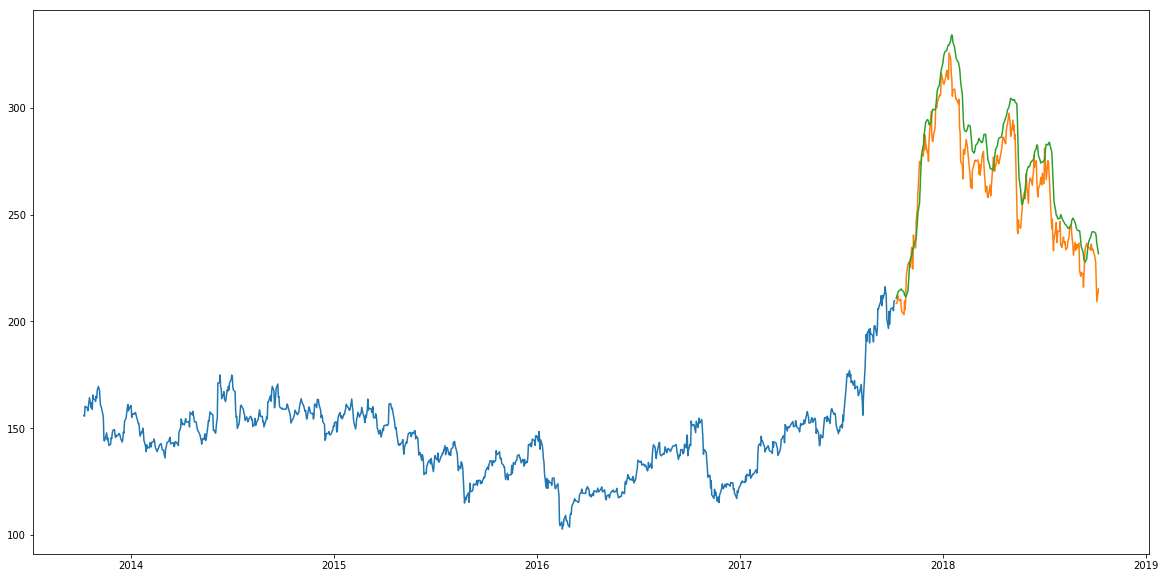

In [40]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

Inference

Wow! The LSTM model can be tuned for various parameters such as changing the number of LSTM layers, adding dropout value or increasing the number of epochs. But are the predictions from LSTM enough to identify whether the stock price will increase or decrease? Certainly not!

As I mentioned at the start of the article, stock price is affected by the news about the company and other factors like demonetization or merger/demerger of the companies. There are certain intangible factors as well which can often be impossible to predict beforehand.